In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import sparse
from scipy.spatial.distance import cosine # cosine類似度に基づくcosine距離（類似していると数値が小さくなる）
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df.max()

user_id            943
item_id           1682
rating               5
timestamp    893286638
dtype: int64

In [4]:
# sparse matrixになることが予想されるので，そちらを使う
# sparse matrixの種類
# lil_matrix : 値のセット用
# csr_matrix：演算用（行を取り出すのが得意）
# csc_matrix:演算用（列を取り出すのが得意）
shape = (df.max().loc['user_id'], df.max().loc['item_id'])
R = sparse.lil_matrix(shape)

for i in df.index:
    row = df.loc[i]
    R[row['user_id']-1, row['item_id']-1] = row['rating']
    

In [5]:
def compute_item_similarities(R):
    # n: movie counts
    n = R.shape[1]
    sims = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                # 同じitemは類似度1.0
                sim = 1.0
            else:
                # R[:, i]はアイテムiに関する全ユーザの評価を並べた列ベクトル
                # item baseの協調フィルタリングでは，あるitemの全ユーザの評価を比べて類似度を計算する
                sim = similarity(R[:,i], R[:,j])
            
            sims[i][j] = sim
            sims[j][i] = sim
            
    return sims

In [6]:
def similarity(item1, item2):
    # item1とitem2のどちらも評価済であるユーザの集合(True, Falseの列ベクトルが戻り値)
    common = np.logical_and(item1 != 0, item2 != 0)
    
    v1 = item1[common]
    v2 = item2[common]
    
    sim = 0.0
    
    # あるitem　に関する評価者が２以上に限る
    if v1.size > 1:
        sim = 1.0 - cosine(v1, v2) # scipyのcosine類似度を求めるcosine()はコサイン距離なので改めて1から引く
        
    return sim

In [8]:
R = R.todense()
sims = compute_item_similarities(R)
print(sims) # item　の類似度行列

[[1.         0.94873739 0.91329972 ... 0.         0.         0.        ]
 [0.94873739 1.         0.90887971 ... 0.         0.         0.        ]
 [0.91329972 0.90887971 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [9]:
def predict(u, sims):
    # 未評価は０，評価済は１となるベクトル，normalizersの計算用
    x = np.zeros(u.size)
    x[u > 0] = 1
    
    scores = sims.dot(u)
    normalizers = sims.dot(x)
    
    prediction = np.zeros(u.size)
    for i in range(u.size):
        # 分母が０になるケースと評価済アイテムは予測値を0とする
        # 評価済も0にしているのは，協調フィルタリングで予測したものだけを取り出すため
        if normalizers[i] == 0 or u[i] > 0:
            prediction[i] = 0
        else:
            prediction[i] = scores[i] / normalizers[i]
        
    # ユーザuのアイテムiに対する評価の予測
    return prediction

In [10]:
# matrixからユーザ0の評価列を取り出す
u = np.array(R.tolist()[0])
pred = predict(u, sims)
pred = u + pred # 評価全体は元評価を足す

np.set_printoptions(threshold=np.inf) # notebookでの省略表記を解除
print(u) # 元評価データ
print(pred) # 協調フィルタリング後の評価データ

[5. 3. 4. 3. 3. 5. 4. 1. 5. 3. 2. 5. 5. 5. 5. 5. 3. 4. 5. 4. 1. 4. 4. 3.
 4. 3. 2. 4. 1. 3. 3. 5. 4. 2. 1. 2. 2. 3. 4. 3. 2. 5. 4. 5. 5. 4. 4. 5.
 3. 5. 4. 4. 3. 3. 5. 4. 5. 4. 5. 5. 4. 3. 2. 5. 4. 4. 3. 4. 3. 3. 3. 4.
 3. 1. 4. 4. 4. 1. 4. 4. 5. 5. 3. 4. 3. 5. 5. 4. 5. 4. 5. 3. 5. 2. 4. 5.
 3. 4. 3. 5. 2. 2. 1. 1. 2. 4. 4. 5. 5. 1. 5. 1. 5. 5. 5. 3. 3. 3. 5. 1.
 4. 3. 4. 5. 3. 2. 5. 4. 5. 3. 1. 4. 4. 4. 4. 3. 5. 1. 3. 1. 3. 2. 1. 4.
 2. 4. 3. 2. 2. 5. 4. 5. 3. 5. 2. 4. 4. 3. 3. 4. 4. 4. 4. 3. 5. 5. 2. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 3. 5. 4. 5. 4. 4. 4. 4. 3. 3. 5. 5. 4.
 4. 4. 5. 5. 5. 5. 4. 3. 3. 5. 4. 5. 3. 4. 5. 5. 4. 4. 3. 4. 2. 4. 3. 5.
 3. 3. 1. 3. 5. 4. 5. 5. 2. 3. 4. 5. 4. 4. 1. 3. 2. 4. 5. 4. 2. 4. 4. 3.
 4. 5. 1. 2. 2. 5. 1. 4. 4. 4. 4. 2. 5. 1. 2. 4. 4. 5. 1. 1. 1. 3. 1. 2.
 4. 1. 4. 5. 5. 5. 2. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

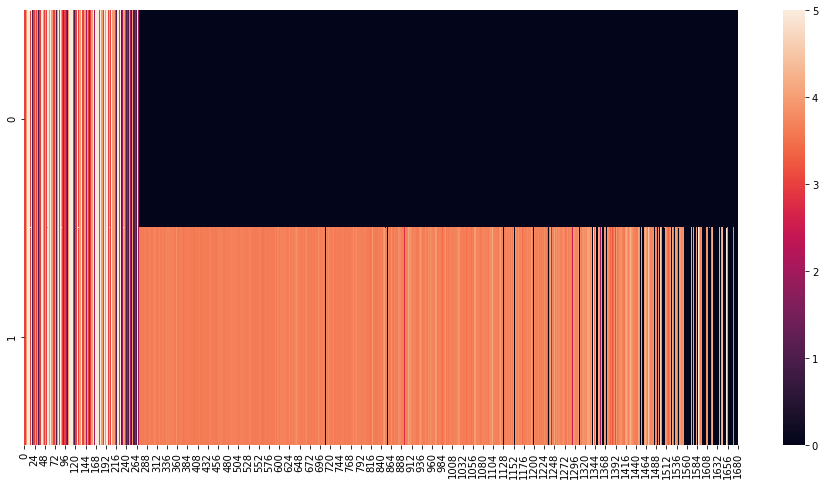

In [11]:
plt.figure(figsize=(16,8))
# sns.heatmap(u)
shape = u.shape
shape_item = shape[0]
shape_item

u = np.append(u, pred, axis=0).reshape((2, shape_item))
sns.heatmap(u)